In [1]:
import ngramNets
import ngramUtilities
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import generateCompleteProteome
from matplotlib.ticker import MultipleLocator, LogLocator, NullFormatter
import seaborn as sns

Importing the complete proteome as a single n-gram network

In [2]:
# Loading pre-computed versions of the n-gram analysis
ref_df, _ = generateCompleteProteome.import_proteome_files()
interpro_dict = ngramUtilities.generate_interpro_conversion(ref_df)

In [3]:
# Creating some default parameters for future plots.
plt.rcParams['font.size'] = 5
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.01

# For the networks to be drawn later
network_params = {'node_size':0.5, 'edgecolors':'k',
        'edge_color':'#808080', 'width':0.05, 'linewidths':0.1}

In [4]:
# Putting a quick summary of how many domains are found within the dataset of interest and the protein count of each
unigrams = {}
for arch in ref_df['Interpro Domain Architecture IDs']:
    spl = arch.split('|')
    for d in set(spl):
        if d not in unigrams:
            unigrams[d] = 0
        unigrams[d] += 1

del unigrams['']

In [5]:
proteome_arch_len = [len(str(x).split('|')) if x != '' else 0 for x in ref_df['Interpro Domain Architecture IDs'].tolist() ]

Text(0, 0.5, 'Protein Count')

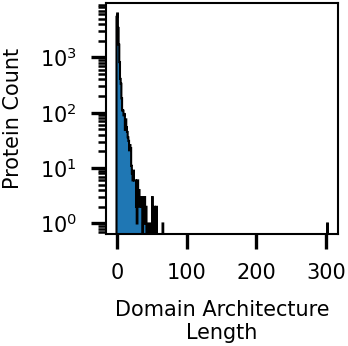

In [6]:
plt.figure(figsize=(1,1), dpi=300, clear=True)
perc_len = plt.hist(proteome_arch_len, bins=range(0,max(proteome_arch_len)+1), edgecolor = 'black',align='left',cumulative=False,density=False,linewidth = 0.5, histtype='stepfilled')
#plt.xlim(-0.75,10.75)
a = plt.gca()
a.set_xticks([0,100,200,300])
plt.yscale('log')
plt.xlabel('Domain Architecture\nLength')
plt.ylabel('Protein Count')

#plt.savefig('Figures/Manuscript Figures/Supplemental Figure 1 Extended Proteome Characterization/Domain Architecture Length Distribution.svg')

Text(0, 0.5, 'Cumulative Fraction')

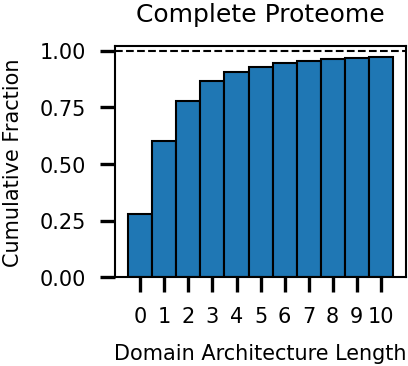

In [7]:
len_2_show = 10
perc_len = plt.hist(proteome_arch_len, bins=range(0,max(proteome_arch_len)+1), edgecolor = 'black',align='left',cumulative=True,density=True,linewidth = 0.5, histtype='stepfilled')
plt.close()

# Now getting the actual figure to be shown
plt.figure(figsize=(1.25,1), dpi=300, clear=True)
plt.bar(x = perc_len[1][:len_2_show+1],height=perc_len[0][:len_2_show+1],width=1,edgecolor='k', linewidth = 0.5 )
a = plt.gca()
a.set_xticks(range(0,11))
plt.title('Complete Proteome')
plt.xlabel('Domain Architecture Length')
plt.axhline(y = 1, xmin=0, xmax = 10, color = 'k', linewidth = 0.5 , linestyle = 'dashed')
plt.ylabel('Cumulative Fraction')
#plt.savefig('Figures/Manuscript Figures/Figure 1 Full Proteome Characterization/N-gram Length Distribution.svg')

# Start to generate the n-gram networks that represent the proteome.

In [ ]:
full_comp = ngramNets.dansy(ref=ref_df,n=67,interproIDs=[k for k in interpro_dict],collapse = False)

Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.


In [9]:
full_pos = nx.spring_layout(full_comp.G, seed = 882)

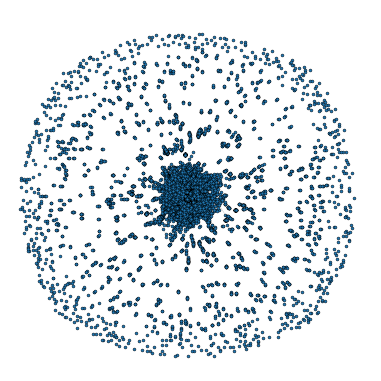

In [10]:
plt.figure(figsize=(1.25,1.25),dpi = 300, clear=True)
nx.draw(full_comp.G, full_pos, **network_params)

Text(0.5, 1.0, 'Domain n-grams')

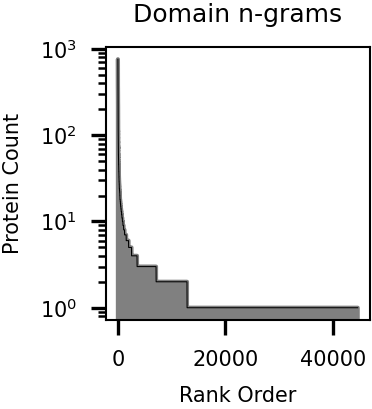

In [11]:
# Generating a waterfall plot of the ngram protein counts to 
ngram_counts = [full_comp.adj.loc[i,i] for i in full_comp.adj.index]
plt.figure(figsize=(1.25,1.25),dpi=300)
plt.plot(range(0,len(full_comp.adj.index)), ngram_counts, linestyle='-',lw = 0.25,color='k')
plt.fill_between(x= range(0, len(full_comp.adj.index)),y1=ngram_counts,  color='gray')
plt.yscale('log')
plt.tight_layout()
plt.ylabel('Protein Count')
plt.xlabel('Rank Order')
plt.title('Domain n-grams')
#plt.savefig('Figures/Manuscript Figures/Figure 1 Full Proteome Characterization/Uncollapsed n-gram protein count waterfall plot.svg', )

In [12]:
col_ngam_uniprots = full_comp.interpro2uniprot

In [13]:
# To characterize the number of unique proteins that are represented in each of the connected components and show the justification of the collapsed network.
cc_prot_len = {}
cc_prot_changes = {}
for idx, cc in enumerate(nx.connected_components(full_comp.G)):
    if len(cc) > 1:
        cc_prot = set([])
        cng_cnts = 0
        for ngram in cc:
            if len(set(col_ngam_uniprots[ngram]).difference(cc_prot)) != 0:
                cc_prot.update(col_ngam_uniprots[ngram])
                cng_cnts += 1

        cc_prot_len[idx] = len(cc_prot)
        cc_prot_changes[idx] = cng_cnts -1 # Subtracting one due to the very first change from an empty set to having something

Text(0, 0.5, 'Connected Components')

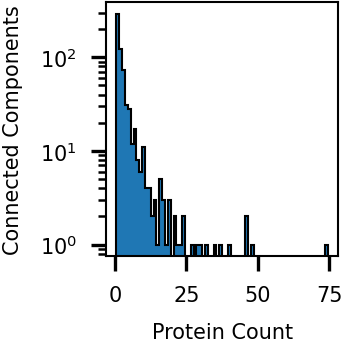

In [14]:
# Now plotting the number of proteins associated with each connected component
plt.figure(figsize=(1.0,1.1), dpi=300)
plt.hist([v for v in cc_prot_len.values()], bins=range(1, 76),edgecolor = 'black',align='left',cumulative=False,density=False,linewidth = 0.5, histtype='stepfilled')
plt.yscale('log')
plt.xlabel('Protein Count')
plt.xticks(ticks=[0,25,50,75])
plt.ylabel('Connected Components')
#plt.savefig('Figures/Manuscript Figures/Supplemental Figure 1 Extended Proteome Characterization/Connected Components Protein Count Distribution.svg')

In [ ]:
collapsed_net = ngramNets.dansy(ref=ref_df,n=67, interproIDs=[k for k in interpro_dict.keys()])

Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.


In [16]:
collapse_pos = nx.spring_layout(collapsed_net.G, seed=882)

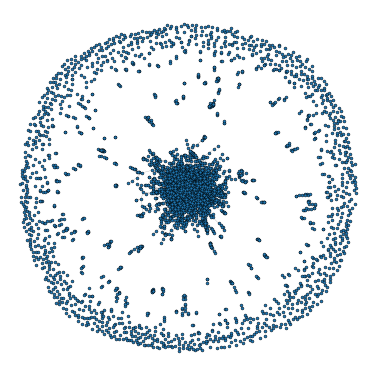

In [17]:
plt.figure(figsize=(1.25,1.25),dpi = 300, clear=True)
nx.draw(collapsed_net.G, collapse_pos, **network_params)

In [18]:
isols = [nx.number_of_isolates(full_comp.G), nx.number_of_isolates(collapsed_net.G)]
ccs = [nx.number_connected_components(full_comp.G), nx.number_connected_components(collapsed_net.G)]

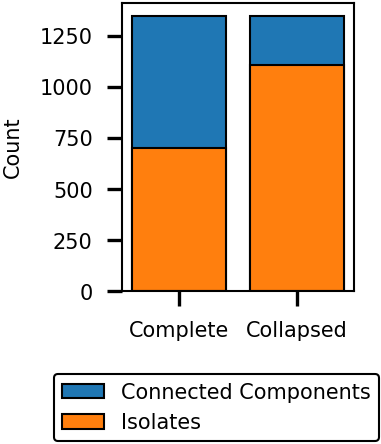

In [19]:
plt.figure(figsize=(1,1.25),dpi = 300)
plt.bar(x = ['Complete','Collapsed'],height=ccs, label='Connected Components', edgecolor='k', linewidth=0.5)
plt.bar(x = ['Complete','Collapsed'],height=isols, label = 'Isolates',edgecolor='k', linewidth=0.5)
plt.ylabel('Count')
l = plt.legend(edgecolor='k',framealpha=1, bbox_to_anchor=(1.15,-0.25))
l.get_frame().set_linewidth(0.5)
#plt.savefig('Figures/Manuscript Figures/Supplemental Figure 1 Extended Proteome Characterization/Collapsed Network Connected Components Comparison.svg')

In [20]:
isols_lengths = [len(str(x).split('|')) for x in nx.isolates(collapsed_net.G)]
isols_lengths_c = [len(str(x).split('|')) for x in nx.isolates(full_comp.G)]

Text(0, 0.5, 'Isolates')

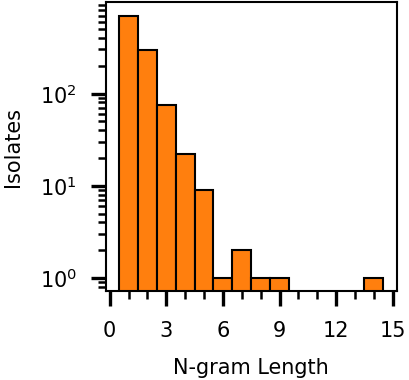

In [21]:
plt.figure(figsize=(1.25,1.25),dpi=300,clear=True)

plt.hist(isols_lengths, bins=range(1,max(isols_lengths)+2), edgecolor = 'k',align='left',linewidth = 0.5,color='tab:orange')
a = plt.gca()
a.set_xticks(np.arange(0,16,3))
a.xaxis.set_minor_locator(MultipleLocator(1))
plt.yscale('log')
plt.xlabel('N-gram Length')
plt.ylabel('Isolates')
#plt.savefig('Figures/Manuscript Figures/Supplemental Figure 1 Extended Proteome Characterization/Collapsed Isolates N-gram Lengths.svg',)

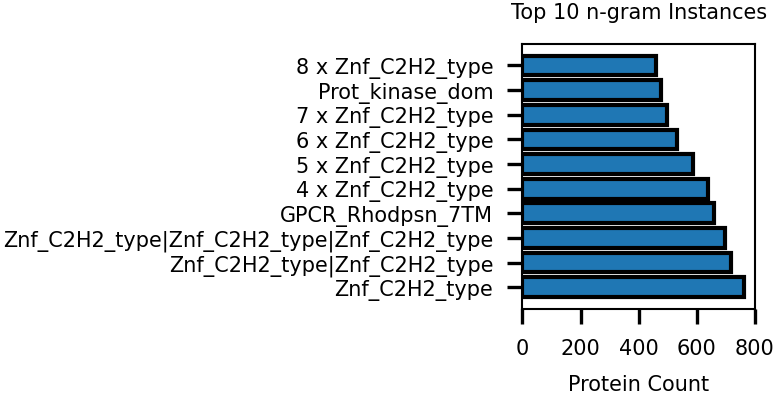

In [22]:
indepth_characterization_cands = set()

top_ngrams = []
for i in collapsed_net.adj.index[:10]:
    ind_split = i.split('|')
    i_conv = []
    for j in ind_split:
        i_conv.append(interpro_dict[j])
        indepth_characterization_cands.add(j)
    if len(i_conv) > 3 and len(set(i_conv)) == 1:
        top_ngrams.append("%i x %s"%(len(i_conv),i_conv[0]))
    else:
        i_conv = '|'.join(i_conv)
        top_ngrams.append(i_conv)

plt.figure(figsize=(1,1.15),dpi=300,clear=True)
plt.barh(top_ngrams, [collapsed_net.adj.loc[i,i] for i in collapsed_net.adj.index[:10]],edgecolor='black')
plt.xlabel('Protein Count')
plt.title('Top 10 n-gram Instances',fontdict={'size':5})
a = plt.gca()
a.set_xticks(np.linspace(0,800,5))
#plt.savefig('Figures/Manuscript Figures/Supplemental Figure 1 Extended Proteome Characterization/Top 10 N-gram Instances.svg')

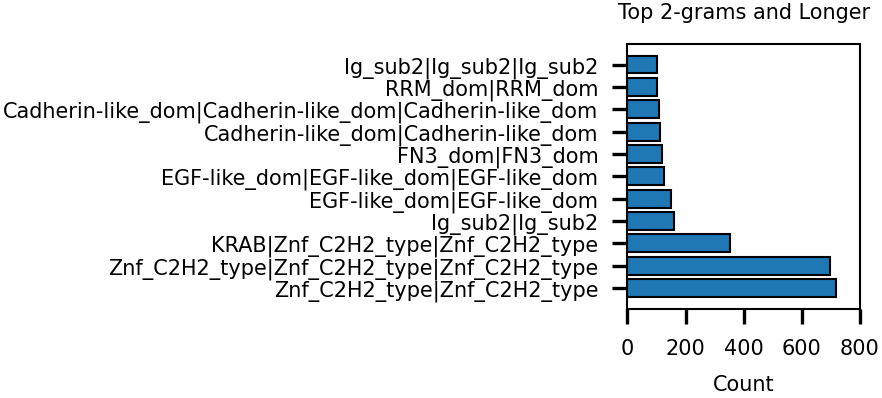

In [23]:
# Repeating the above, but for 2+ grams instead of singular domains.


top_cnt = 0
i = 0
ngram_2_plot = []
while top_cnt < 11:
    ngramOI = collapsed_net.adj.index[i]
    if len(ngramOI.split('|')) >= 2:
        if len(set(ngramOI.split('|'))) > 2:
            ngram_2_plot.append(ngramOI)
            top_cnt += 1
        elif len(ngramOI.split('|')) <= 3:
            ngram_2_plot.append(ngramOI)
            top_cnt += 1
    i += 1


top_ngrams = []
for i in ngram_2_plot:
    ind_split = i.split('|')
    i_conv = []
    for j in ind_split:
        i_conv.append(interpro_dict[j])
        indepth_characterization_cands.add(j)
    i_conv = '|'.join(i_conv)
    top_ngrams.append(i_conv)



plt.figure(figsize=(1,1.15),dpi=300,clear=True)
plt.barh(top_ngrams, [collapsed_net.adj.loc[i,i] for i in ngram_2_plot],linewidth=0.5, edgecolor='k')
plt.xlabel('Count')
plt.title('Top 2-grams and Longer',fontdict={'size':5})
a = plt.gca()
a.set_xticks(np.linspace(0,800,5))

#plt.savefig('Figures/Manuscript Figures/Supplemental Figure 1 Extended Proteome Characterization/Top 10 Bigrams and longer Instances.svg')

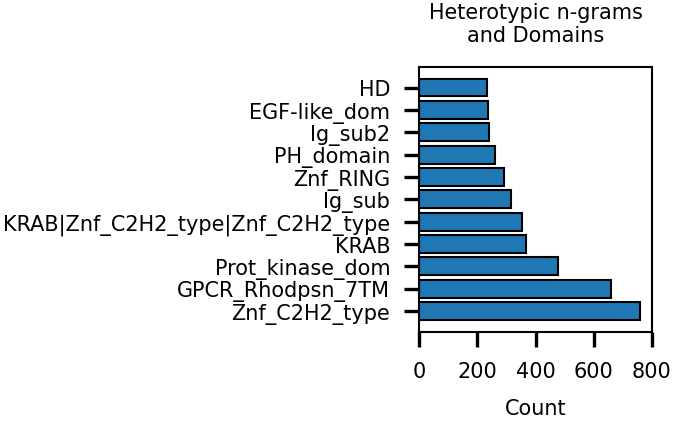

In [24]:
# Repeating the above, but for 2+ grams with more than 1 domain
top_cnt = 0
i = 0
ngram_2_plot = []
while top_cnt < 11:
    ngramOI = collapsed_net.adj.index[i]
    if (len(set(ngramOI.split('|'))) >= 2 and len(ngramOI.split('|')) <= 3) or (len(ngramOI.split('|')) == 1):
        ngram_2_plot.append(ngramOI)
        top_cnt += 1
    i += 1

top_ngrams = []
for i in ngram_2_plot:
    ind_split = i.split('|')
    i_conv = []
    for j in ind_split:
        i_conv.append(interpro_dict[j])
        indepth_characterization_cands.add(j)
    
    i_conv = '|'.join(i_conv)
    top_ngrams.append(i_conv)

plt.figure(figsize=(1,1.15),dpi=300,clear=True)
plt.barh(top_ngrams, [collapsed_net.adj.loc[i,i] for i in ngram_2_plot],linewidth = 0.5, edgecolor='k')
plt.xlabel('Count')
plt.title('Heterotypic n-grams\nand Domains', fontdict={'size':5})
a = plt.gca()
a.set_xticks(np.linspace(0,800,5))

#plt.savefig('Figures/Manuscript Figures/Supplemental Figure 1 Extended Proteome Characterization/Top 10 Heterotypic N-gram Instances.svg')

In [25]:
# Here using the top heterotypic n-grams to retrieve specific features of these domains specifically the amino acid length and count within individual proteins
dom_details = {}
for dom in indepth_characterization_cands:
    dom_cnts = []
    dom_sizes = []
    x = col_ngam_uniprots[dom]
    prot_info = ref_df[ref_df['UniProt ID'].isin(x)]
    for _, row in prot_info.iterrows():
        inner_cnt = 0
        arch_info = row['Interpro Domains'].split(';')
        for prot_dom in arch_info:
            if dom in prot_dom:
                inner_cnt += 1
                dom_info = prot_dom.split(':')
                dom_sz = int(dom_info[3]) - int(dom_info[2])
                dom_sizes.append(dom_sz)

        dom_cnts.append(inner_cnt)
    
    dom_details[dom] = {'Intraprotein Instances':dom_cnts,
                        'Amino Acid Sizes':dom_sizes}


In [26]:
szOnly = {k:v['Amino Acid Sizes'] for k, v in dom_details.items()}
doms, data = [*zip(*szOnly.items())]
doms = [interpro_dict[d] for d in doms]

Text(0, 0.5, 'Amino Acid Length')

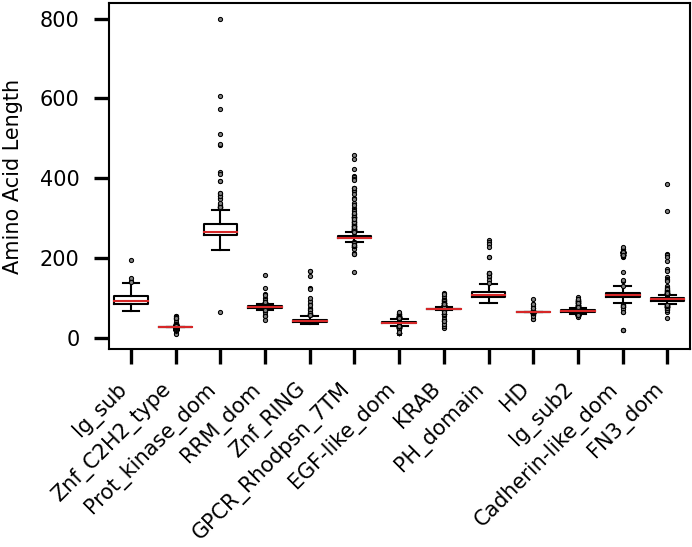

In [27]:
szOnly = {k:v['Amino Acid Sizes'] for k, v in dom_details.items()}
doms, data = [*zip(*szOnly.items())]
doms = [interpro_dict[d] for d in doms]

plt.figure(figsize=(2.5,1.5), dpi=300)
plt.boxplot(data, widths=0.75,
            flierprops={'marker':'o', 'markerfacecolor':'gray','markersize':1, 'markeredgecolor':'k','markeredgewidth':0.25},
            medianprops={'linewidth':0.5,'color':'tab:red'},
            boxprops={'linewidth':0.5},
            whiskerprops={'linewidth':0.5},
            capprops={'linewidth':0.5})
a = plt.gca()
a.set_xticks(range(1, len(data)+1),labels=doms, rotation=45, horizontalalignment='right')
plt.ylabel('Amino Acid Length')
#plt.savefig('Figures/Manuscript Figures/Supplemental Figure 1 Extended Proteome Characterization/Highly Recurring Domain Amino Acid Length.svg')

Now using the network metrics to generate some summary characteristics of the individual n-grams

In [32]:
large_cc = max(nx.connected_components(collapsed_net.G), key =len)
dc = nx.degree_centrality(collapsed_net.G.subgraph(large_cc))
bc = nx.betweenness_centrality(collapsed_net.G.subgraph(large_cc))

In [33]:
both_cents = {k:{'Degree':dc[k],'Betweeness':bc[k]} for k in large_cc}

# Also adding in the protein count 
for k in both_cents:
    try:
        both_cents[k]['Count'] = collapsed_net.adj.loc[k,k]
    except:
        print(k) # This is one of the unique Tintin n-grams
        both_cents[k]['Count'] = 1

both_cents = pd.DataFrame.from_dict(both_cents, orient='index')

In [34]:
both_cents['B-Rank'] = both_cents['Betweeness'].rank(ascending=False,method='min')
both_cents['D-Rank'] = both_cents['Degree'].rank(ascending=False,method='min')
both_cents['C-Rank'] = both_cents['Count'].rank(ascending=False,method='min')
both_cents['Average Rank'] = both_cents.filter(['B-Rank','D-Rank']).mean(axis=1).rank(ascending=True,method='min')
both_cents.sort_values('Average Rank', ascending=True, inplace=True)

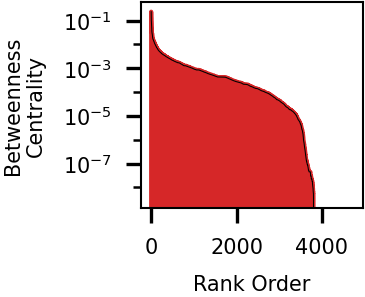

In [35]:
# Plotting the distribution of the two centrality measures to show how they look overall and then showing a heatmap of the top 10-20 in their rank

# First Reordering according to the betweenness rank
both_cents.sort_values('B-Rank', ascending=True, inplace=True)

plt.figure(figsize=(1.15,1),dpi=300)
plt.plot(range(0,len(both_cents.index)), both_cents['Betweeness'], linestyle='-',lw = 0.25,color='k')
plt.fill_between(x= range(0, len(both_cents.index)),y1=both_cents['Betweeness'],  color='tab:red')
plt.yscale('log')
plt.tight_layout()
plt.ylabel('Betweenness\nCentrality')
plt.xlabel('Rank Order')
a = plt.gca()
a.yaxis.set_major_locator(LogLocator(numticks=5))
a.yaxis.set_minor_locator(LogLocator(numticks=10))
a.yaxis.set_minor_formatter(NullFormatter())

#plt.savefig('Figures/Manuscript Figures/Figure 1 Full Proteome Characterization/Betweennesss Centrality.svg')

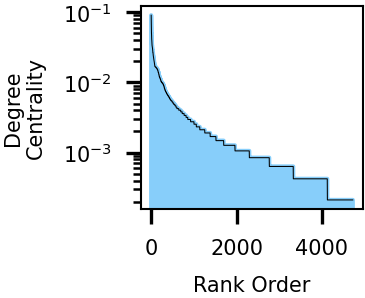

In [36]:
# First Reordering according to the degree centrality rank
both_cents.sort_values('D-Rank', ascending=True, inplace=True)

plt.figure(figsize=(1.15,1),dpi=300)
plt.plot(range(0,len(both_cents.index)), both_cents['Degree'], linestyle='-',lw = 0.25,color='k')
plt.fill_between(x= range(0, len(both_cents.index)),y1=both_cents['Degree'],  color='lightskyblue')
plt.yscale('log')
plt.tight_layout()
plt.ylabel('Degree\nCentrality')
plt.xlabel('Rank Order')
a = plt.gca()


#plt.savefig('Figures/Manuscript Figures/Figure 1 Full Proteome Characterization/Degree Centrality.svg')

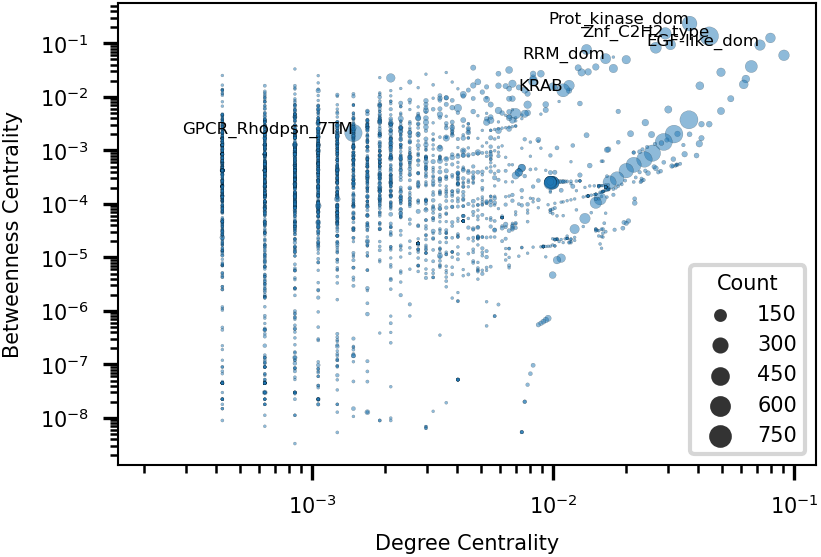

In [37]:
# Getting a handful of domains to highlight based on results up to this point.
ngrams_2_highlight = ['IPR000719','IPR013087','IPR001909','IPR000742','IPR017452','IPR000504']

plt.figure(figsize=(3,2),dpi=300)
sns.scatterplot(both_cents, x = 'Degree',y = 'Betweeness',size='Count',alpha=0.5,edgecolor='k', sizes=(0.5,20))

# Adding text for the domains that are highlighted
for i in ngrams_2_highlight:
    plt.text(x = both_cents.loc[i,'Degree'],y =both_cents.loc[i,'Betweeness'], s=interpro_dict[i],fontdict={'size':4},horizontalalignment='right')
plt.xlabel('Degree Centrality')
plt.ylabel('Betweenness Centrality')
plt.xscale('log')
plt.yscale('log')
#plt.savefig('Figures/Manuscript Figures/Figure 1 Full Proteome Characterization/Centrality Bubbleplot.svg')

In [30]:
collapsed_net.summary(detailed=True)

,
name,Domain n-gram Network
Proteins,19354
n-grams,6621
Network Isolates,1106
Network Connected Components,1345
Collapsed n-grams,37997
Network Edges,28457
Maximum Length of Protein Domain Architecture,303


In [31]:
full_comp.summary(detailed=True)

,
name,Domain n-gram Network
Proteins,19354
n-grams,44618
Network Isolates,700
Network Connected Components,1345
Collapsed n-grams,0
Network Edges,8714810
Maximum Length of Protein Domain Architecture,303
